## Proyecto de Clasificación de Imágenes de F1 - Modelo 2: Pytorch CNN + Transfer Lerning + Fine Tuning

**Autor:** Geónimo Pautazzo
**Fecha:** 14 de Octubre de 2025

### Objetivo del Notebook

Este notebook replica el proceso de construcción del clasificador CNN, pero utilizando el framework **PyTorch**. El objetivo es comparar el flujo de trabajo y el rendimiento con el modelo desarrollado en Keras.

Se aplicará la misma técnica de **Transfer Learning** con `EfficientNetB0` y se utilizará **Optuna** para la optimización de hiperparámetros.

El proceso incluye:
1.  Carga de datos con `torchvision`.
2.  Entrenamiento de un modelo base y diagnóstico de sobreajuste.
3.  Optimización de hiperparámetros con **Optuna**.
4.  Entrenamiento y evaluación detallada del modelo final optimizado.


In [1]:
# Instalacionde librerias pip
# En caso de tener AMD: Usar la API DirectML de Microsoft
# (Direct Machine Learning) que permite a los frameworks de IA usar cualquier tarjeta gráfica compatible con DirectX 12
#!pip install torch-directml


In [ ]:
#Herramientas 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
from trainer import train_loop, val_loop 

#Pytorch
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split

#Pytorch AMD
import torch_directml

#Optuna Busqueda de hiperparametros
import optuna

#Skitlearn
from sklearn.metrics import confusion_matrix, classification_report

### Preparación de Datos con Torchvision

En esta fase, preparamos el pipeline de datos utilizando las herramientas del ecosistema de PyTorch.
+ Definición de Transformaciones
+ Carga de Datos
+ División y Carga

In [3]:
#Parametros globales transformadores y normalizacion
DATA_DIR = "./datos"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

#Data Augmentation (transformaciones)

#pipeline de transformaciones para imagenes de entrenamiento
train_transforms =transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), #convierte la imagen en un Tensor de PyTorch
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalización estándar
])

#pipeline de imagenes de validacion (sin transformaciones)
validation_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalización estándar
])


In [ ]:
#Carga y division de datos

full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)
class_names = full_dataset.classes
print(f"Clases encontradas: {class_names}")

#divison del dataset en train y val
val_split = 0.2
val_size = int(val_split * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, validation_dataset = random_split(full_dataset,[train_size, val_size])

#Sobre escribir la transformaciones del conjunto de validacion para que no use el aumeto de datos
validation_dataset.dataset.transform = validation_transforms

#Crear los DataLoaders (iteradores de los lotes de datos)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"\nDatasets listos: {len(train_dataset)} imágenes para entrenar, {len(validation_dataset)} para validar.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Clases encontradas: ['crash', 'f1', 'safety_car']

Datasets listos: 123 imágenes para entrenar, 30 para validar.


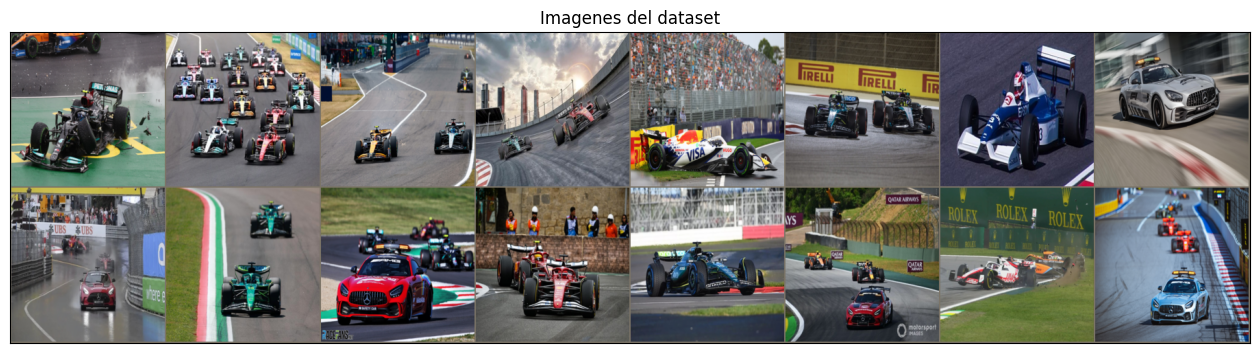

In [5]:
#Visualizacion de un lote de imagenes
# Función para desnormalizar y mostrar la imagen
def imshow(inp, title="Imagenes del dataset", size=(16, 16)):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=size)  # Agranda la imagen
    plt.imshow(inp)
    plt.xticks([])  # Elimina los números del eje X
    plt.yticks([])  # Elimina los números del eje Y
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Obtenemos un lote de datos de entrenamiento
inputs, classes = next(iter(train_loader))

# Mostramos las imágenes del lote
imshow(make_grid(inputs))

In [6]:
# Contruccion del modelo con pytorch

# Determinar el dispositivo (obligatorio [GPU si esta disponible o CPU])

# PyTorch nos permite (y obliga a) ser explícitos sobre dónde se ejecutan los cálculos.
# Si tienes una GPU con CUDA (Nvidia), la usaremos para acelerar todo.
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch_directml.device() #Para AMD
print(f"Usando dispositivo: {device}")

# Cargar modelo base pre entrenado EfficientNet-B0
model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Congelar los pesos del modelo base
for param in model.parameters():
    param.requires_grad = False

# Reemplazar la capa fina (cabezal clasificador) "classifier"
#Obtener numero de features que entrar al clasificador
num_features = model.classifier[1].in_features
NUM_CLASSES = len(class_names)

# Clasificador nuevo
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_features, NUM_CLASSES) #capa de salida para las 3 clases
)

#ubicar el modelo en el dispositivo correcto (CPU o GPU)
model = model.to(device)

#funcion loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr= 0.0001)
print("\n¡Modelo construido y listo para entrenar!")
print("\nArquitectura del modelo (Summuary):")
print(model)

Usando dispositivo: privateuseone:0

¡Modelo construido y listo para entrenar!

Arquitectura del modelo (Summuary):
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (ac

In [ ]:
#Bucle principal de entrenamiento
NUM_EPOCHS = 15
best_val_acc = 0.0

#Historial de entrenamiento
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("Iniciando el entrenamiento...")

for epoch in range(NUM_EPOCHS):
    stat_time = time.time()
    print(f"\nÉpoca {epoch+1}/{NUM_EPOCHS}")
    print("-" * 20)

    train_loss, train_acc = train_loop(model, device, train_loader, criterion, optimizer)
    val_loss, val_acc = val_loop(model, device, validation_loader, criterion)

    # Guardamos las métricas de la época actual
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_duration = time.time() - stat_time
    print(f"Duración: {epoch_duration:.2f}s")
    print(f"Loss de Entrenamiento: {train_loss:.4f} | Acc de Entrenamiento: {train_acc:.4f}")
    print(f"Loss de Validación: {val_loss:.4f}   | Acc de Validación: {val_acc:.4f}")


print("\n¡Entrenamiento completado!")
print(f"Mejor precisión en validación: {best_val_acc:.4f}")

# Para usar el mejor modelo guardado, cargaríamos los pesos así:
# model.load_state_dict(torch.load('f1_classifier_pytorch_cnn.pth'))

Iniciando el entrenamiento...

Época 1/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Urano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\adam.py:534: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)


Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 5.77s
Loss de Entrenamiento: 1.0834 | Acc de Entrenamiento: 0.3577
Loss de Validación: 1.0679   | Acc de Validación: 0.3667
=> Modelo guardado (mejor Acc de validación)

Época 2/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 3.55s
Loss de Entrenamiento: 1.0705 | Acc de Entrenamiento: 0.3821
Loss de Validación: 1.0392   | Acc de Validación: 0.5000
=> Modelo guardado (mejor Acc de validación)

Época 3/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 3.24s
Loss de Entrenamiento: 1.0446 | Acc de Entrenamiento: 0.4878
Loss de Validación: 1.0246   | Acc de Validación: 0.5333
=> Modelo guardado (mejor Acc de validación)

Época 4/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 3.47s
Loss de Entrenamiento: 1.0263 | Acc de Entrenamiento: 0.5447
Loss de Validación: 1.0084   | Acc de Validación: 0.6333
=> Modelo guardado (mejor Acc de validación)

Época 5/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 3.53s
Loss de Entrenamiento: 1.0335 | Acc de Entrenamiento: 0.5041
Loss de Validación: 0.9980   | Acc de Validación: 0.6667
=> Modelo guardado (mejor Acc de validación)

Época 6/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 3.09s
Loss de Entrenamiento: 1.0035 | Acc de Entrenamiento: 0.5447
Loss de Validación: 0.9859   | Acc de Validación: 0.6667

Época 7/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 2.75s
Loss de Entrenamiento: 0.9885 | Acc de Entrenamiento: 0.5528
Loss de Validación: 0.9714   | Acc de Validación: 0.6667

Época 8/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 2.74s
Loss de Entrenamiento: 0.9770 | Acc de Entrenamiento: 0.6179
Loss de Validación: 0.9622   | Acc de Validación: 0.7333
=> Modelo guardado (mejor Acc de validación)

Época 9/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 2.88s
Loss de Entrenamiento: 0.9554 | Acc de Entrenamiento: 0.6667
Loss de Validación: 0.9529   | Acc de Validación: 0.6667

Época 10/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 2.85s
Loss de Entrenamiento: 0.9349 | Acc de Entrenamiento: 0.7073
Loss de Validación: 0.9393   | Acc de Validación: 0.6667

Época 11/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 2.95s
Loss de Entrenamiento: 0.9130 | Acc de Entrenamiento: 0.6911
Loss de Validación: 0.9305   | Acc de Validación: 0.6667

Época 12/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 3.06s
Loss de Entrenamiento: 0.8961 | Acc de Entrenamiento: 0.7236
Loss de Validación: 0.9200   | Acc de Validación: 0.7667
=> Modelo guardado (mejor Acc de validación)

Época 13/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 3.03s
Loss de Entrenamiento: 0.8788 | Acc de Entrenamiento: 0.7642
Loss de Validación: 0.9100   | Acc de Validación: 0.8000
=> Modelo guardado (mejor Acc de validación)

Época 14/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 3.10s
Loss de Entrenamiento: 0.8903 | Acc de Entrenamiento: 0.7317
Loss de Validación: 0.8976   | Acc de Validación: 0.7667

Época 15/15
--------------------


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 2.99s
Loss de Entrenamiento: 0.8514 | Acc de Entrenamiento: 0.7886
Loss de Validación: 0.8851   | Acc de Validación: 0.8000

¡Entrenamiento completado!
Mejor precisión en validación: 0.8000


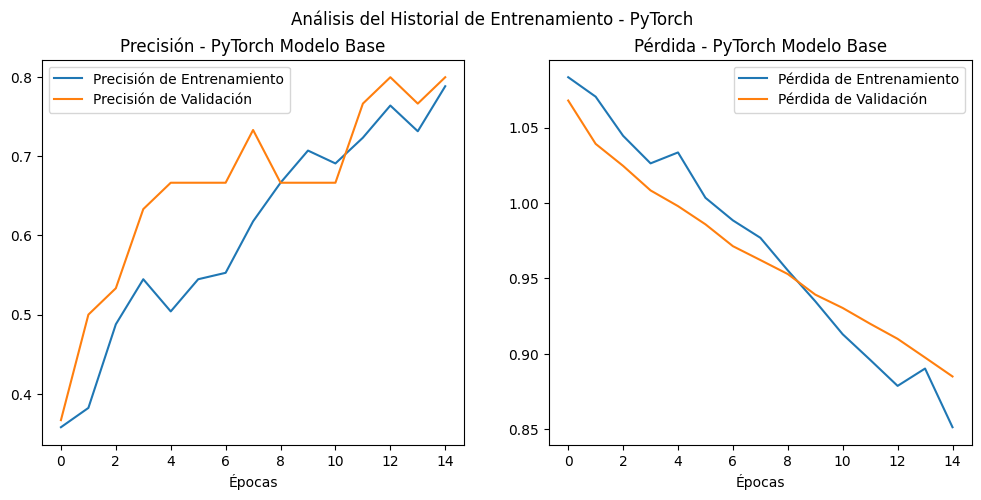

In [10]:
# Visualización de las Curvas de Entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Precisión de Entrenamiento')
plt.plot(history['val_acc'], label='Precisión de Validación')
plt.legend()
plt.title('Precisión - PyTorch Modelo Base')
plt.xlabel('Épocas')

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.legend()
plt.title('Pérdida - PyTorch Modelo Base')
plt.xlabel('Épocas')

plt.suptitle('Análisis del Historial de Entrenamiento - PyTorch')
plt.show()


El modelo está aprendiendo a generalizar (val_accuracy decente, de un 67%), pero todavía está "demasiado enfocado" en los datos de entrenamiento. Hay una "brecha" de rendimiento de casi el 20% entre lo que sabe hacer con datos conocidos y con datos nuevos.

Para cerrar esa brecha del 20% y llevar el rendimiento del 67% al nivel del 90%+ que sabemos que es posible (gracias a Keras), se procedió a una búsqueda sistemática de hiperparámetros con Optuna.

In [11]:
# Busqueda de Hiperparametros con Optuna
def objective(trial):
    """
    Esta es la función que Optuna intentará optimizar.
    Un 'trial' es un único intento o ejecución del proceso.
    """
    # Definir el Espacio de Búsqueda
    # Sugerimos los hiperparámetros que Optuna debe probar.
    # HP1: Tasa de Aprendizaje (en escala logarítmica, muy efectivo)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # HP2: Tasa de Dropout
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)

    # Construir el Modelo (dentro del trial)
    # Reconstruimos el modelo en cada trial para asegurarnos de que esté limpio.
    model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate), # Usamos el dropout del trial
        nn.Linear(num_ftrs, NUM_CLASSES)
    )
    model = model.to(device)

    # Definir Optimizador y Criterio
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=lr) # Usamos el lr del trial
    criterion = nn.CrossEntropyLoss()

    # Bucle de Entrenamiento y Validación (simplificado para la búsqueda)
    NUM_EPOCHS_SEARCH = 15 
    for epoch in range(NUM_EPOCHS_SEARCH):
        # Solo necesitamos el rendimiento de validación para optimizar
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    #Evaluar y Devolver la Métrica
    model.eval()
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            
    val_acc = correct_predictions.double() / len(validation_loader.dataset)
    
    # Optuna necesita que le devolvamos el valor a optimizar
    return val_acc.item()


#Iniciar el Estudio de Optimización
# Le decimos a Optuna que queremos maximizar la métrica.
study = optuna.create_study(direction="maximize")
# Iniciamos la búsqueda. 20 trials son un buen punto de partida.
study.optimize(objective, n_trials=20)

print("\n¡Búsqueda de hiperparámetros completada!")
print("Número de trials finalizados: ", len(study.trials))
print("Mejor trial:")
trial = study.best_trial

print(f"  Valor (val_accuracy): {trial.value:.4f}")
print("  Mejores Hiperparámetros: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-10-08 17:46:04,087] A new study created in memory with name: no-name-4c8c083a-488a-4b59-9f4e-0633e9656baf
[I 2025-10-08 17:46:39,250] Trial 0 finished with value: 0.8000000715255737 and parameters: {'lr': 0.015445042918079216, 'dropout': 0.22154977828729833}. Best is trial 0 with value: 0.8000000715255737.
[I 2025-10-08 17:47:14,285] Trial 1 finished with value: 0.5333333611488342 and parameters: {'lr': 5.8092371499509654e-05, 'dropout': 0.2631327024082808}. Best is trial 0 with value: 0.8000000715255737.
[I 2025-10-08 17:47:47,742] Trial 2 finished with value: 0.8000000715255737 and parameters: {'lr': 0.006589212809859996, 'dropout': 0.4283074844173444}. Best is trial 0 with value: 0.8000000715255737.
[I 2025-10-08 17:48:20,008] Trial 3 finished with value: 0.8333333730697632 and parameters: {'lr': 0.006907576580119623, 'dropout': 0.37012178891419}. Best is trial 3 with value: 0.8333333730697632.
[I 2025-10-08 17:48:52,485] Trial 4 finished with value: 0.9000000357627869 and p


¡Búsqueda de hiperparámetros completada!
Número de trials finalizados:  20
Mejor trial:
  Valor (val_accuracy): 0.9000
  Mejores Hiperparámetros: 
    lr: 0.0003405251229628468
    dropout: 0.3375315022074885


In [ ]:
# Recuperar los mejores hiperparametros de optuna
best_params = study.best_trial.params
best_lr = best_params["lr"]
best_dropout = best_params["dropout"]

print("Usando los Hiperparámetros Óptimos Encontrados: ")
print(f"Mejor Tasa de Aprendizaje: {best_lr:.6f}")
print(f"Mejor Tasa de Dropout: {best_dropout:.4f}")

# Construccion del modelo optimizado
final_model = models.efficientnet_b0(weights="IMAGENET1K_V1")
for param in final_model.parameters():
    param.requires_grad = False

num_features = final_model.classifier[1].in_features
final_model.classifier = nn.Sequential(
    nn.Dropout(p=best_dropout), # mejor dropout
    nn.Linear(num_features, NUM_CLASSES)
)
final_model = final_model.to(device)

#Definir Optimizador y Criterio para el Modelo Final
optimizer = torch.optim.Adam(final_model.classifier.parameters(), lr=best_lr) # mejor lr
criterion = nn.CrossEntropyLoss()

Usando los Hiperparámetros Óptimos Encontrados: 
Mejor Tasa de Aprendizaje: 0.000341
Mejor Tasa de Dropout: 0.3375


In [ ]:
#Entrenamiento del modelo final
NUM_EPOCHS_FINAL = 30 #se entrena por mas epocas para mejejorar la conjergencia 
best_val_acc = 0.0
# Listas para guardar el historial
history_final = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

print("\nIniciando el entrenamiento del modelo final...")

for epoch in range(NUM_EPOCHS_FINAL):
    print(f"\nÉpoca {epoch+1}/{NUM_EPOCHS_FINAL}")
    train_loss, train_acc = train_loop(final_model, device, train_loader, criterion, optimizer)
    val_loss, val_acc = val_loop(final_model, device, validation_loader, criterion)
    
    # Guardamos las métricas de la época
    history_final['train_loss'].append(train_loss)
    history_final['train_acc'].append(train_acc)
    history_final['val_loss'].append(val_loss)
    history_final['val_acc'].append(val_acc)
    
    print(f"Loss de Validación: {val_loss:.4f} | Acc de Validación: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(final_model.state_dict(), 'f1_classifier_pytorch_cnn.pth')
        print("=> Modelo final guardado (mejor Acc)")

print("\nEntrenamiento Final Completado.")



Iniciando el entrenamiento del modelo final...

Época 1/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 1.1247 | Acc de Validación: 0.3000
=> Modelo final guardado (mejor Acc)

Época 2/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 1.0617 | Acc de Validación: 0.4333
=> Modelo final guardado (mejor Acc)

Época 3/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 1.0283 | Acc de Validación: 0.5000
=> Modelo final guardado (mejor Acc)

Época 4/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.9922 | Acc de Validación: 0.6667
=> Modelo final guardado (mejor Acc)

Época 5/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.9501 | Acc de Validación: 0.7667
=> Modelo final guardado (mejor Acc)

Época 6/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.9158 | Acc de Validación: 0.8000
=> Modelo final guardado (mejor Acc)

Época 7/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.8947 | Acc de Validación: 0.7333

Época 8/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.8658 | Acc de Validación: 0.8000

Época 9/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.8352 | Acc de Validación: 0.8000

Época 10/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.8142 | Acc de Validación: 0.8000

Época 11/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.7838 | Acc de Validación: 0.8667
=> Modelo final guardado (mejor Acc)

Época 12/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.7651 | Acc de Validación: 0.9000
=> Modelo final guardado (mejor Acc)

Época 13/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.7445 | Acc de Validación: 0.9000

Época 14/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.7253 | Acc de Validación: 0.9000

Época 15/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.7073 | Acc de Validación: 0.9000

Época 16/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.6908 | Acc de Validación: 0.9000

Época 17/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.6699 | Acc de Validación: 0.9000

Época 18/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.6616 | Acc de Validación: 0.9000

Época 19/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.6442 | Acc de Validación: 0.9000

Época 20/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.6362 | Acc de Validación: 0.8667

Época 21/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.6353 | Acc de Validación: 0.8333

Época 22/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.6188 | Acc de Validación: 0.8667

Época 23/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.6028 | Acc de Validación: 0.9000

Época 24/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.5945 | Acc de Validación: 0.9000

Época 25/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.5768 | Acc de Validación: 0.9000

Época 26/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.5747 | Acc de Validación: 0.9000

Época 27/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.5656 | Acc de Validación: 0.9000

Época 28/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.5628 | Acc de Validación: 0.9000

Época 29/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.5613 | Acc de Validación: 0.8667

Época 30/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Loss de Validación: 0.5468 | Acc de Validación: 0.9000

Entrenamiento Final Completado.


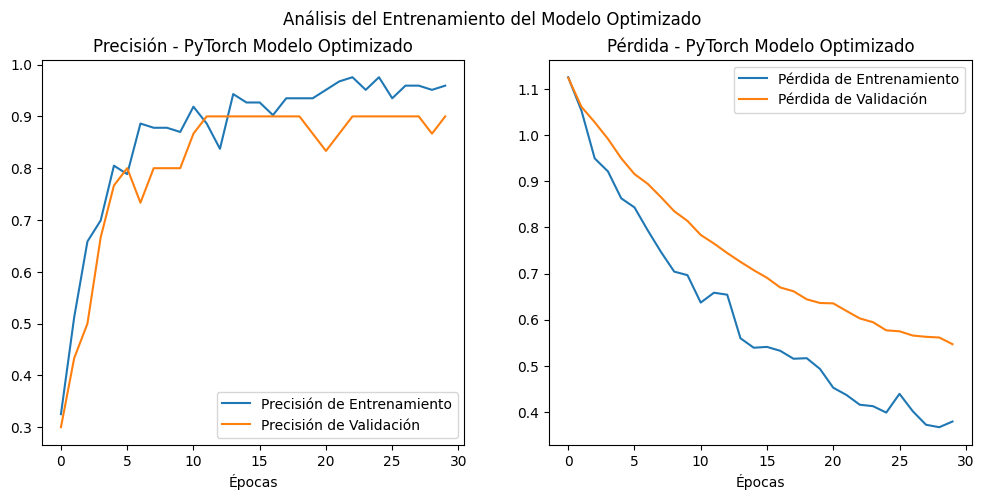

In [14]:
#Visualizar las Curvas del Modelo Optimizado 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_final['train_acc'], label='Precisión de Entrenamiento')
plt.plot(history_final['val_acc'], label='Precisión de Validación')
plt.legend()
plt.title('Precisión - PyTorch Modelo Optimizado')
plt.xlabel('Épocas')

plt.subplot(1, 2, 2)
plt.plot(history_final['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history_final['val_loss'], label='Pérdida de Validación')
plt.legend()
plt.title('Pérdida - PyTorch Modelo Optimizado')
plt.xlabel('Épocas')
plt.suptitle('Análisis del Entrenamiento del Modelo Optimizado')
plt.show()


C:\Users\Urano\AppData\Local\Temp\ipykernel_2392\1984889271.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('f1_classifier_pytorch

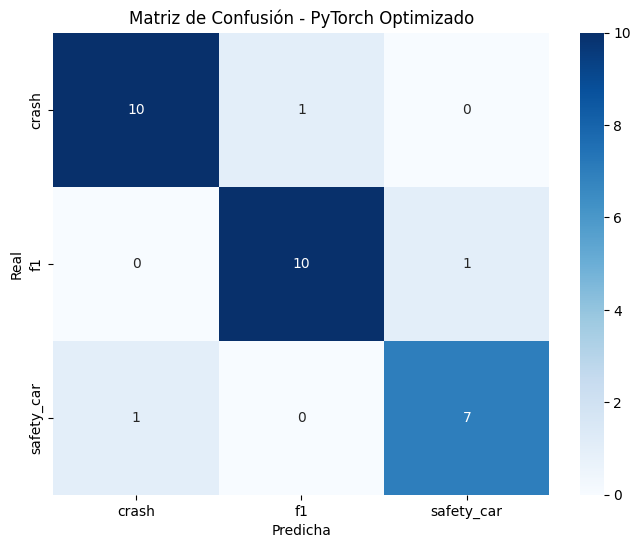


     REPORTE DE CLASIFICACIÓN - PYTORCH OPTIMIZADO
              precision    recall  f1-score   support

       crash       0.91      0.91      0.91        11
          f1       0.91      0.91      0.91        11
  safety_car       0.88      0.88      0.88         8

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



In [15]:
# Carga del mejor modelo y Evaluacion Final 
final_model.load_state_dict(torch.load('f1_classifier_pytorch_cnn_OPTIMIZED.pth'))
final_model.eval()

y_pred, y_true = [], []
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Matriz de Confusión
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicha'), plt.ylabel('Real'), plt.title('Matriz de Confusión - PyTorch Optimizado')
plt.show()

# Reporte de Clasificación
print("\n" + "="*60)
print("     REPORTE DE CLASIFICACIÓN - PYTORCH OPTIMIZADO")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))
print("="*60)


## Conclusión del Notebook

La optimización con Optuna fue crucial y exitosa. Se corrigió el problema de sobreajuste del modelo base, y el modelo final optimizado alcanzó una precisión del **90%** en el conjunto de validación. Este resultado es muy competitivo en comparación con la implementación en Keras. El modelo final fue guardado en el archivo `f1_classifier_pytorch_cnn_OPTIMIZED.pth`.

Este notebook demuestra la capacidad de resolver el mismo problema en PyTorch, destacando las diferencias en el flujo de trabajo, como la necesidad de escribir un bucle de entrenamiento manual y el uso de librerías como Optuna para la optimización.